In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import typesetting.main as tm
import numpy as np
import os
from corrLib import readdata
from corr_utils import *
tm.prl('1-column-2-panel')
dirs = data_log_mapping(kw='aug')

# Plans

- <del>finish the calculation for all samples</del>
- <del>draw the kinetics plot (including energy and order) for all samples</del>
- <del>summarize the density fluctuation results (both dynamics and kinetics)</del>
- <del>order parameter calculation seems different from previous version (where shift matrix was used), check the consistency</del>
- 30 n0 data look strange. In correlation length data, they show larger errorbars, and in df data, they show unexpected nonmonotonic trend.
    - indeed, one of the 30 n0 video shows collective motion while the other two don't. This leads to the $l_{vv}$ value larger than expected. However, the low $\alpha$ value has no good explanation yet.
- The low velocity and concentration correlation may result from including the kinetics part of data. It is intuitive that the correlation is weak when bacterial turbulence is now fully developed. Try exclude the initial part!

## 1. Velocity correlation

Text(0, 0.5, '$l_{vv}/l_b$')

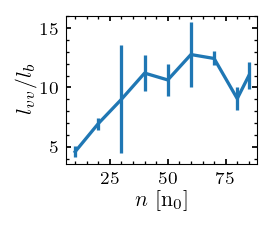

In [51]:
data = pd.read_excel(io=r'E:\Google Drive\Research projects\DF\data\new_data_summary.xlsx', sheet_name='corrV')
data = data.dropna()
plt.errorbar(data['conc'], data['avg']*0.33/3, yerr=data['std']*0.33/3)
plt.xlabel('$n$ [n$_0$]')
plt.ylabel('$l_{vv}/l_b$')

In [15]:
# summarize data
# sample 10 frames out of the last 1/3 of frames
corr_data_path = r'E:\moreData\08052020\cav_imseq'
num_sample = 20 # number of frames to sample
sample_clA = []
sample_clV = []
sfL = next(os.walk(corr_data_path))[1]
sfL_new = []
for s in sfL:
#     print('sample ' + str(n))
    corr_data_path_num = os.path.join(corr_data_path, s)
    
    # sample 20 frames in the last 1/3 frames
    
    l = len(corrLib.readdata(corr_data_path_num))
    if l > 60:
        samples = np.random.randint((l*2/3)/2, (l-1)/2, num_sample) * 2
        clAL = []
        clVL = []
        for i in samples:
            data_raw = pd.read_csv(os.path.join(corr_data_path_num, '{0:04d}-{1:04d}.csv'.format(i, i+1))) # X Y CA CV
            data_AV = xy_to_r(data_raw).sort_values(by=['R'])     
            clA, fit = corr_length(data_AV.rename(columns={'CA': 'C'}), fitting_range=500)
            clV, fit = corr_length(data_AV.rename(columns={'CV': 'C'}), fitting_range=500)
            clAL.append(clA)
            clVL.append(clV)
        sample_clA.append(np.array(clAL).mean())
        sample_clV.append(np.array(clVL).mean())
        sfL_new.append(int(s))
    else:
        raise ValueError('Too few data to sample from. Need at least 60 .csv files.')
summary = pd.DataFrame({'sample': sfL_new, 'clA': sample_clA, 'clV': sample_clV})
summary.to_csv(os.path.join(corr_data_path, 'summary.csv'), index=False)
### Needs further improvement

In [5]:
corr_data_path = r'E:\moreData\08052020\cav_imseq'
sfL = next(os.walk(corr_data_path))[1]
sfL

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11']

In [3]:
dirs

{'120': ['08062020-3', '08062020-4', '08062020-5'],
 '100': ['08062020-0', '08062020-1', '08062020-2'],
 '85': ['08052020-3', '08052020-4', '08052020-5'],
 '80': ['08032020-0', '08032020-1', '08032020-2'],
 '70': ['08042020-0', '08042020-1', '08042020-2'],
 '60': ['08032020-3', '08032020-4', '08032020-5'],
 '50': ['08042020-3', '08042020-4', '08042020-5'],
 '40': ['08032020-6', '08032020-7', '08032020-8'],
 '30': ['08042020-6', '08042020-7', '08042020-8'],
 '20': ['08032020-9', '08032020-10', '08032020-11'],
 '10': ['08042020-9', '08042020-10', '08042020-11'],
 '00': ['08032020-12', '08032020-13', '08032020-14']}

In [36]:
# retrieve data from cav_imseq/summary.csv
folder = r'E:\moreData'
subfolder_name = 'cav_imseq'
data = {'conc': [], 'clA_avg': [], 'clV_avg': [], 'clA_std': [], 'clV_std': []}
for kw in dirs:
    if kw != '00':
        conc = int(kw)
        for n, dn in enumerate(dirs[kw]):
            date, num = dn.split('-')
            summary_dir = os.path.join(folder, date, subfolder_name, 'summary.csv')
            temp = pd.read_csv(summary_dir, index_col='sample').loc[[int(num)]]
            if n == 0:
                conc_data = temp
            else:
                conc_data = conc_data.append(temp)
        data['conc'].append(conc)
        data['clA_avg'].append(conc_data.clA.mean())
        data['clV_avg'].append(conc_data.clV.mean())
        data['clA_std'].append(conc_data.clA.std())
        data['clV_std'].append(conc_data.clV.std())

In [39]:
pd.DataFrame(data)

,conc,clA_avg,clV_avg,clA_std,clV_std
0,120,131.100812,111.828270,28.195589,12.638994
1,100,161.152071,96.753156,89.188712,9.837196
2,85,141.072291,100.711927,30.304600,14.873771
3,80,79.118514,82.306710,8.986337,8.614581
4,70,130.699408,113.078446,19.173139,5.336671
5,60,124.650246,116.078907,37.929393,24.759475
6,50,106.842831,96.616186,10.622119,12.428217
7,40,107.955754,101.865676,22.076049,13.505755
8,30,101.501364,81.795533,25.253006,41.343303
9,20,66.145536,63.173435,6.840477,4.618811


In [ ]:
date = '08062020'

## 2. Concentration correlation

Text(0, 0.5, '$l_{nn}/l_b$')

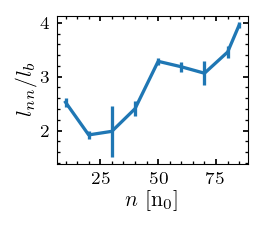

In [52]:
data = pd.read_excel(io=r'E:\Google Drive\Research projects\DF\data\new_data_summary.xlsx', sheet_name='corrI')
data = data.dropna()
plt.errorbar(data['conc'], data['avg']*0.33/3, yerr=data['std']*0.33/3)
plt.xlabel('$n$ [n$_0$]')
plt.ylabel('$l_{nn}/l_b$')

**Comments:** Bpass is still needed.

## 3. Density fluctuations 

Text(0, 0.5, '$\\alpha$')

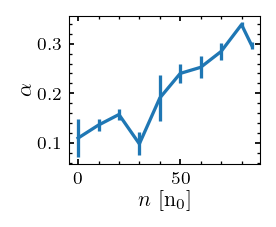

In [53]:
data = pd.read_excel(io=r'E:\Google Drive\Research projects\DF\data\new_data_summary.xlsx', sheet_name='df2')
data = data.dropna()
plt.errorbar(data['conc'], data['avg'], yerr=data['std'])
plt.xlabel('$n$ [n$_0$]')
plt.ylabel('$\\alpha$')

## 4. Density fluctuation kinetics

|concentration|sample 1|sample 2|sample 3|
|:---------:|:---------:|:---------:|:---------:|
|85|![](temp_data\kinetics_eo\85-1.png)|![](temp_data\kinetics_eo\85-2.png)|![](temp_data\kinetics_eo\85-3.png)|
|80|![](temp_data\kinetics_eo\80-1.png)|![](temp_data\kinetics_eo\80-2.png)|![](temp_data\kinetics_eo\80-3.png)|
|70|![](temp_data\kinetics_eo\70-1.png)|![](temp_data\kinetics_eo\70-2.png)|![](temp_data\kinetics_eo\70-3.png)|
|60|![](temp_data\kinetics_eo\60-1.png)|![](temp_data\kinetics_eo\60-2.png)|![](temp_data\kinetics_eo\60-3.png)|
|50|![](temp_data\kinetics_eo\50-1.png)|![](temp_data\kinetics_eo\50-2.png)|![](temp_data\kinetics_eo\50-3.png)|
|40|![](temp_data\kinetics_eo\40-1.png)|![](temp_data\kinetics_eo\40-2.png)|![](temp_data\kinetics_eo\40-3.png)|
|30|![](temp_data\kinetics_eo\30-1.png)|![](temp_data\kinetics_eo\30-2.png)|![](temp_data\kinetics_eo\30-3.png)|
|20|![](temp_data\kinetics_eo\20-1.png)|![](temp_data\kinetics_eo\20-2.png)|![](temp_data\kinetics_eo\20-3.png)|
|10|![](temp_data\kinetics_eo\10-1.png)|![](temp_data\kinetics_eo\10-2.png)|![](temp_data\kinetics_eo\10-3.png)|
|0|![](temp_data\kinetics_eo\0-1.png)|![](temp_data\kinetics_eo\0-2.png)|![](temp_data\kinetics_eo\0-3.png)|

## 5. Correlation between concentration and velocity

In [9]:
#summarize data
folder = r'E:\moreData\08052020\div_x_dcadv'
l = readdata(folder)
for num, i in l.iterrows():
    f, n = os.path.split(i.Dir)
    f, n = os.path.split(f)
    if num == 0:
        data = pd.read_csv(i.Dir).assign(sample=n)
    else:
        data = data.append(pd.read_csv(i.Dir).assign(sample=n))
data = data.set_index('sample')
data.to_csv(os.path.join(folder, 'summary.csv'))

In [8]:
help(readdata)

Help on function readdata in module corrLib:

readdata(folder)



In [11]:
# retrieve data from each day's summary
folder = r'E:\moreData'
count = 0
for kw in dirs: 
    avg, std = retrieve_dxd_data(folder, dirs[kw])
    avg = avg.rename(columns={'avg': kw}).transpose()
    std = avg.rename(columns={'std': kw}).transpose(), 
    if count == 0:
        avg_data = avg
        std_data = std
        count = 1
    else:
        avg_data = avg_data.append(avg)
        std_data = avg_data.append(std)

Text(0, 0.5, 'Correlation')

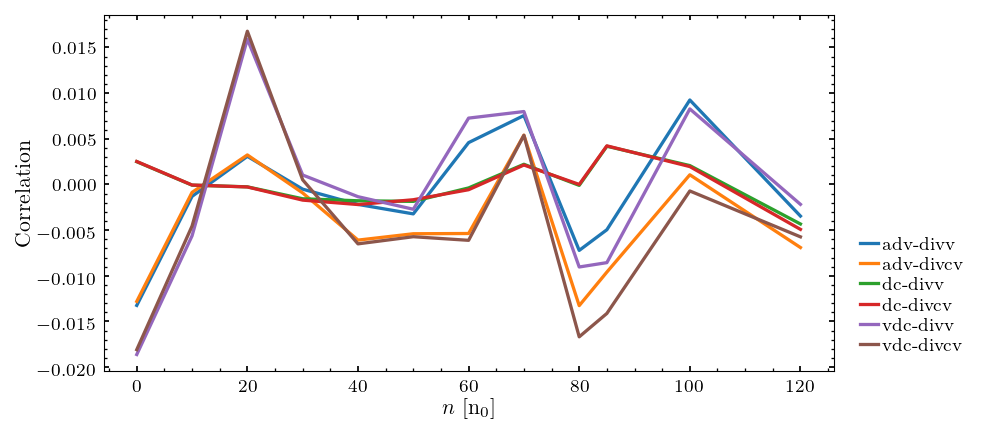

In [12]:
# plot
plt.figure(figsize=(6, 3))
x = np.array(avg_data.index).astype('int32')
for kw in avg_data:
    if kw != 'dt':        
        plt.plot(x, avg_data[kw], label=kw.replace('_', '-'))
plt.legend(loc=4, bbox_to_anchor=(1.2, 0))
plt.xlabel('$n$ [n$_0$]')
plt.ylabel('Correlation')

## 6. Dimensionality effect

Probe dimensionality effect by gradually changing the chamber thickness (200, 140, 100, <del>20</del>)

In [10]:
data = pd.read_excel(r'E:\Google Drive\Research projects\DF\data\new_data_summary.xlsx', sheet_name='dimensionality').dropna()

Text(0, 0.5, '$\\alpha$')

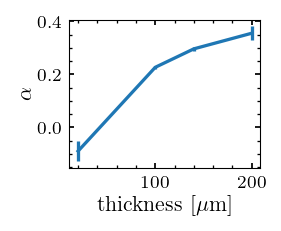

In [15]:
plt.errorbar(data['thickness'], data['alpha_avg'], yerr=data['alpha_std'])
plt.xlabel('thickness [$\mu$m]')
plt.ylabel('$\\alpha$')

Text(0, 0.5, 'energy [px$^2$/s$^2$]')

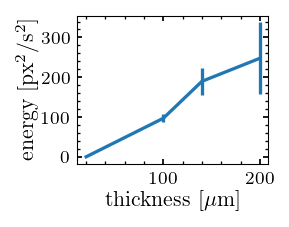

In [17]:
plt.errorbar(data['thickness'], data['energy_avg'], yerr=data['energy_std'])
plt.xlabel('thickness [$\mu$m]')
plt.ylabel('energy [px$^2$/s$^2$]')

**<font color='red'>Question:</font>** when reducing chamber thickness, the density fluctuation scaling exponent does decrease. However, the flow energy decreases at the mean time. This observation has posed a question: does thickness influence the overall motility of bacteria, or just suppress interaction between bacteria by approaching two dimensional settings? 

## 7. Debug dxd code

In [20]:
div = pd.read_csv('temp_data\dxd_bug\div.csv')
dc_adv = pd.read_csv('temp_data\dxd_bug\dc_adv.csv')

In [27]:
col = len(div.x.drop_duplicates())
row = len(div.y.drop_duplicates())

In [29]:
div.columns

Index(['x', 'y', 'divcn', 'divcv', 'divv'], dtype='object')

In [30]:
dc_adv.columns

Index(['x', 'y', 'dcx', 'dcy', 'dc', 'adv', 'vdc'], dtype='object')

In [39]:
mat1 = np.array(div.divv).reshape(row, col)
mat2 = np.array(dc_adv.adv).reshape(row, col)

In [40]:
mat1 = (mat1 - mat1.mean()) / mat1.std()
mat2 = (mat2 - mat2.mean()) / mat2.std()

In [46]:
(mat1 * mat2).mean()

0.038087017838403035

In [31]:
np.random.seed(1)
a = np.random.randn(2, 2)
b = np.random.randn(2, 2)
from scipy import signal
signal.correlate2d(a, b, 'same')

array([[ 2.70889276, -2.40154694],
       [ 2.01239494, -0.92855523]])

**Result:** the mismatch in coordinates is not the cause of the empty dxd data.

In [51]:
dcadv_folder = r'E:\moreData\08052020\dc_adv\00\dt=60'
l = readdata(dcadv_folder)

In [54]:
l.loc[l.index>len(l)*0.9]

,Name,Dir
1594,3188-3248,E:\moreData\08052020\dc_adv\00\dt=60\3188-3248...
1595,3190-3250,E:\moreData\08052020\dc_adv\00\dt=60\3190-3250...
1596,3192-3252,E:\moreData\08052020\dc_adv\00\dt=60\3192-3252...
1597,3194-3254,E:\moreData\08052020\dc_adv\00\dt=60\3194-3254...
1598,3196-3256,E:\moreData\08052020\dc_adv\00\dt=60\3196-3256...
...,...,...
1765,3530-3590,E:\moreData\08052020\dc_adv\00\dt=60\3530-3590...
1766,3532-3592,E:\moreData\08052020\dc_adv\00\dt=60\3532-3592...
1767,3534-3594,E:\moreData\08052020\dc_adv\00\dt=60\3534-3594...
1768,3536-3596,E:\moreData\08052020\dc_adv\00\dt=60\3536-3596...
